<a href="https://colab.research.google.com/github/PWhiddy/jax-experiments/blob/main/EmotionsGPUFast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install einops pynvml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
import imageio
import time
import torch
import math
import torchvision
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange
from tqdm.notebook import trange, tqdm


In [11]:
device = "cuda" # "cpu"
ctx = torch.amp.autocast(device_type=device, dtype=torch.float16)

In [12]:
class Activation (nn.Module):
    def forward(self, x):
        return  nn.functional.relu(x)
class NN(nn.Module):
    def __init__(self, n_freqs,n_emotions, hidden_sizes, output_size):
        super(NN, self).__init__()
        self.n_freqs = n_freqs
        self.n_emotions = n_emotions
        input_size = n_freqs*2+n_emotions
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size

        # Define the layers of the network
        layers = []
        sizes = [input_size] + hidden_sizes + [output_size]
        for i in range(len(sizes)-1):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if i < len(sizes)-2:
                layers.append(Activation())
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        freqs = 2.0 ** torch.arange(self.n_freqs, device=device)
        emotions = 2.0 ** torch.arange(self.n_emotions, device=device)
        # create a tensor of angles for each frequency
        x_angles = x[:,0].unsqueeze(-1) * freqs
        y_angles = x[:,1].unsqueeze(-1) * freqs
        emotions = x[:,2].unsqueeze(-1) * emotions

        # compute the sine waves for each frequency and concatenate them
        x_waves = torch.sin(x_angles)
        y_waves = torch.sin(y_angles)
        x = torch.cat((emotions,x_waves, y_waves), dim=-1)
    
        x = x.view(-1, self.input_size)
        out = self.net(x)
        return out

In [13]:
img = torchvision.io.read_image("faces.png").float() / 255.0 #.permute(1,2,0)/255


In [14]:
# trim off extra pixels so image divides evenly, drop alpha
trimmed = img[:3, :-1, :-2]
faces_t = rearrange(trimmed, "d (r h) (c w)-> (r c) d h w", r=3, c=6)
faces_t.shape

torch.Size([18, 3, 419, 281])

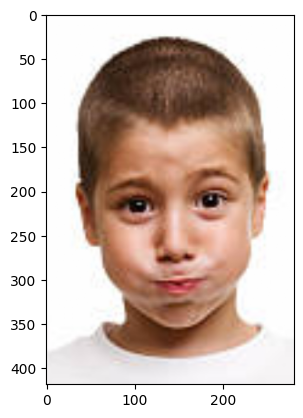

In [15]:
plt.imshow(faces_t[11].permute(1,2,0))

In [16]:
dims = faces_t.shape
fc, yc, xc = torch.meshgrid(
    torch.linspace(0, 1, dims[0], device=device), 
    torch.linspace(0, 1, dims[2], device=device), 
    torch.linspace(0, 1, dims[3], device=device), indexing="ij")

In [17]:
coord_inputs = torch.stack((fc.flatten(), yc.flatten(), xc.flatten()), dim=1).to(device)
pix_outputs = rearrange(faces_t, "b c h w-> (b h w) c").to(device)
pix_outputs.shape

torch.Size([2119302, 3])

In [18]:
net = NN(n_freqs = 10, n_emotions = 3, hidden_sizes=[256,256,256], output_size=3)
net = net.to(device)
opt = torch.optim.AdamW(net.parameters(), lr=0.001)

In [19]:

image_count = faces_t.shape[0]
batch_size = 4*2048
#train_loader = torch.utils.data.DataLoader(Data(images), batch_size=batch_size, shuffle=True)
for i in range(30):
  for j in range(1000):
    pix_indices = torch.randint(coord_inputs.shape[0], (batch_size,), device=device)
    input = coord_inputs[pix_indices]
    output = pix_outputs[pix_indices]
    with ctx:
      pred = net(input)
    loss = ((pred - output) ** 2).mean()
    
    loss.backward()
    opt.step()
    opt.zero_grad()
  print(loss.item())

0.007026532664895058
0.0047056227922439575
0.004144309554249048
0.0033086449839174747
0.0027431040070950985
0.0025108770933002234
0.0023089535534381866
0.002593998098745942
0.0020411289297044277
0.0018770413007587194
0.0021042865701019764
0.001923500094562769
0.001783554209396243
0.001785638160072267
0.0017554861260578036
0.0015434216475114226
0.001624800032004714
0.0014908674638718367
0.0015981625765562057
0.0013900136109441519
0.0015870294300839305
0.001384509145282209
0.0014888723380863667
0.0014020231319591403
0.0014301377814263105
0.0013300729915499687
0.0014469701563939452
0.001314962049946189
0.0012278303038328886
0.0013072686269879341
0.0014040383975952864
0.0012103135231882334
0.00136971240863204
0.0015668931882828474
0.0014224400511011481
0.0011974724475294352
0.0011180058354511857
0.0011674732668325305
0.001169862225651741
0.0011237355647608638
0.0010958684142678976
0.0013568622525781393
0.0010983934625983238
0.0011644825572147965
0.001398417865857482
0.001002608216367662
0.

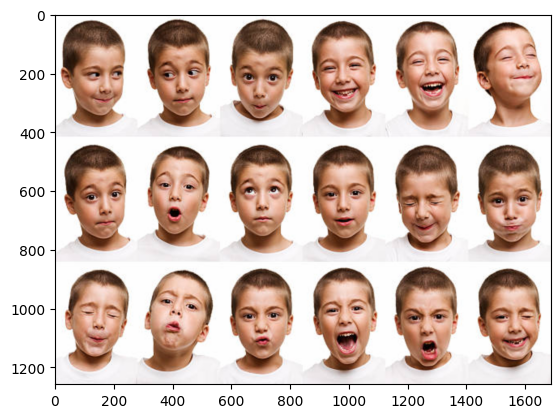

torch.Size([1258, 1688, 4])


In [20]:

img_plot = torchvision.io.read_image("faces.png").float().permute(1,2,0)/255

plt.imshow(img_plot)
plt.show()
print(img_plot.shape)

images = []
n_i = 6
n_j = 3
for j in range(3):
    for i in range(6):
        y1 = math.floor(j/n_j*img_plot.shape[0])
        y2 = math.floor((j+1)/n_j*img_plot.shape[0])
        x1 = math.floor(i/n_i*img_plot.shape[1])
        x2 = math.floor((i+1)/n_i*img_plot.shape[1])
        face = img_plot[y1:y2,x1:x2, :]
        images.append(face)
        #plt.imshow(face)
        #plt.show()


In [21]:
w = 300
h = 450
yy, xx = torch.meshgrid(torch.linspace(0, 1, h), torch.linspace(0, 1, w), indexing="ij")
frames = []
for i in trange(200):
  j = i/100
  if (i>100):
    j = (200-i)/100
  f = torch.ones_like(xx)*j*(len(images)-1)/len(images)
  inputs = torch.stack((f.flatten(), yy.flatten(), xx.flatten()), dim=1)
  with torch.no_grad(), ctx:
    tensor_np = torch.clamp(net(inputs.to(device)).reshape(h,w,3).detach(),min=0,max=1).cpu().numpy()
  tensor_np_norm = ((tensor_np - tensor_np.min()) / (tensor_np.max() - tensor_np.min())) * 255
  #imageio.imwrite(f'frame_{i}.png', tensor_np_norm.astype('uint8'))
  frames.append(tensor_np_norm.astype('uint8'))

imageio.mimsave('animation.gif', frames, duration=.1)

  0%|          | 0/200 [00:00<?, ?it/s]